# Efficient Performance Prediction for advanced analytics on Apache Spark
### Goal : Extend and analyse the model that published by DataBricks
### Ernest: Efficient Performance Prediction for Large-Scale Advanced A


In [404]:
#from google.colab import drive
#drive.mount('/content/drive')

In [405]:
import numpy as np
import scipy
from scipy.optimize import nnls
import csv
import sys
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

read data points of executors from a saved csv file :

In [406]:
executorsDF=pd.read_csv("spark_executorsInfo.csv")

In [407]:
executorsDF

,Unnamed: 0,id,hostPort,isActive,rddBlocks,memoryUsed,diskUsed,totalCores,maxTasks,activeTasks,...,totalInputBytes,totalShuffleRead,totalShuffleWrite,isBlacklisted,maxMemory,addTime,executorLogs,memoryMetrics,blacklistedInStages,app_id
0,0,driver,tribarco7cm.gc18bd.tributos.local:40397,True,0,0,0,0,0,0,...,0,0,0,False,956615884,2021-12-17T12:09:22.283GMT,{'stdout': 'http://tribarco7cm.gc18bd.tributos...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
1,1,3,tribarco7cm.gc18bd.tributos.local:43508,True,0,0,0,2,2,0,...,0,1210170,808945,False,2101975449,2021-12-17T12:09:31.286GMT,{'stdout': 'http://tribarco7cm.gc18bd.tributos...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
2,2,2,tribarco7n03.gc18bd.tributos.local:42441,True,0,0,0,2,2,0,...,0,436282,786169,False,2101975449,2021-12-17T12:09:32.215GMT,{'stdout': 'http://tribarco7n03.gc18bd.tributo...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
3,3,1,tribarco7n03.gc18bd.tributos.local:34991,True,0,0,0,2,2,0,...,0,743902,795240,False,2101975449,2021-12-17T12:09:32.537GMT,{'stdout': 'http://tribarco7n03.gc18bd.tributo...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
4,4,driver,tribarco7cm.gc18bd.tributos.local:40397,True,0,0,0,0,0,0,...,0,0,0,False,956615884,2021-12-17T12:09:22.283GMT,{'stdout': 'http://tribarco7cm.gc18bd.tributos...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,463,driver,tribarco7n03.gc18bd.tributos.local:40503,True,0,0,0,0,0,0,...,0,0,0,False,384093388,2021-12-16T19:47:51.214GMT,{'stdout': 'http://tribarco7n03.gc18bd.tributo...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
464,464,2,tribarco7cm.gc18bd.tributos.local:34006,True,0,0,0,1,1,0,...,0,581000,1450828,False,384093388,2021-12-16T19:48:15.755GMT,{'stdout': 'http://tribarco7cm.gc18bd.tributos...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
465,465,1,tribarco7n03.gc18bd.tributos.local:40328,True,0,0,0,1,1,0,...,13400,5146052,4276833,False,384093388,2021-12-16T19:47:55.784GMT,{'stdout': 'http://tribarco7n03.gc18bd.tributo...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168
466,466,driver,tribarco7n03.gc18bd.tributos.local:35765,True,0,0,0,0,0,0,...,0,0,0,False,384093388,2021-12-16T19:47:18.441GMT,{'stdout': 'http://tribarco7n03.gc18bd.tributo...,"{'usedOnHeapStorageMemory': 0, 'usedOffHeapSto...",[],application_1637600037062_1168


Data preprocessing 

 we clean our data and just keep the most important variables to use them in our performance model later:

In [408]:
executorsDF.describe()

,Unnamed: 0,rddBlocks,memoryUsed,diskUsed,totalCores,maxTasks,activeTasks,failedTasks,completedTasks,totalTasks,totalDuration,totalGCTime,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory
count,468.000000,468.0,468.0,468.0,468.000000,468.000000,468.0,468.000000,468.000000,468.000000,468.000000,468.000000,4.680000e+02,4.680000e+02,4.680000e+02,4.680000e+02
mean,233.500000,0.0,0.0,0.0,0.826923,0.826923,0.0,0.010684,442.247863,442.258547,19522.570513,346.957265,4.949073e+04,2.391148e+06,2.590059e+06,9.142601e+08
std,135.244224,0.0,0.0,0.0,0.744690,0.744690,0.0,0.102919,2272.890697,2272.888617,55429.441354,545.895412,2.101078e+05,1.153304e+07,1.043271e+07,9.697726e+08
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,116.750000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.840934e+08
50%,233.500000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.000000,2.000000,2.000000,4155.000000,139.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.840934e+08
75%,350.250000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.000000,56.000000,56.000000,20120.000000,494.000000,1.616000e+03,9.019000e+03,1.000500e+04,9.566159e+08
max,467.000000,0.0,0.0,0.0,2.000000,2.000000,0.0,1.000000,17480.000000,17480.000000,323840.000000,2705.000000,1.586952e+06,9.643034e+07,7.298198e+07,3.247335e+09


In [409]:
filteredExecutorsDF=executorsDF[["totalCores","totalTasks","totalInputBytes","totalDuration"]]
tpot_data = executorsDF[["totalCores","totalTasks","totalInputBytes","totalShuffleRead","totalShuffleWrite","maxMemory","totalDuration"]]

In [410]:
filteredExecutorsDF

,totalCores,totalTasks,totalInputBytes,totalDuration
0,0,0,0,0
1,2,141,0,21757
2,2,81,0,20817
3,2,89,0,20800
4,0,0,0,0
...,...,...,...,...
463,0,0,0,0
464,1,27,0,21108
465,1,85,13400,24126
466,0,0,0,0


In [411]:
filteredExecutorsDF.describe()

,totalCores,totalTasks,totalInputBytes,totalDuration
count,468.000000,468.000000,4.680000e+02,468.000000
mean,0.826923,442.258547,4.949073e+04,19522.570513
std,0.744690,2272.888617,2.101078e+05,55429.441354
min,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000
50%,1.000000,2.000000,0.000000e+00,4155.000000
75%,1.000000,56.000000,1.616000e+03,20120.000000
max,2.000000,17480.000000,1.586952e+06,323840.000000


tpot_data is a data frame with extra variables of the executors, in order to use tpot library later to find the
best pipline based on those variables.   


In [412]:

tpot_data

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
0,0,0,0,0,0,956615884,0
1,2,141,0,1210170,808945,2101975449,21757
2,2,81,0,436282,786169,2101975449,20817
3,2,89,0,743902,795240,2101975449,20800
4,0,0,0,0,0,956615884,0
...,...,...,...,...,...,...,...
463,0,0,0,0,0,384093388,0
464,1,27,0,581000,1450828,384093388,21108
465,1,85,13400,5146052,4276833,384093388,24126
466,0,0,0,0,0,384093388,0


In [413]:
clean_tpot_data = tpot_data.drop_duplicates(keep='first')
clean_tpot_data

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
0,0,0,0,0,0,956615884,0
1,2,141,0,1210170,808945,2101975449,21757
2,2,81,0,436282,786169,2101975449,20817
3,2,89,0,743902,795240,2101975449,20800
8,0,0,0,0,0,2101975449,0
9,2,87,0,247,83,3247335014,11948
10,2,72,0,0,83,3247335014,10402
11,2,56,0,0,81,3247335014,12298
13,2,359,0,17908,14746,3247335014,34362
14,2,346,0,16129,14466,3247335014,32653


In [414]:
tpot_data = tpot_data[(tpot_data[['totalCores',"totalTasks"]] != 0).all(axis=1)]
tpot_data

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
1,2,141,0,1210170,808945,2101975449,21757
2,2,81,0,436282,786169,2101975449,20817
3,2,89,0,743902,795240,2101975449,20800
5,2,141,0,1210170,808945,2101975449,21757
6,2,81,0,436282,786169,2101975449,20817
...,...,...,...,...,...,...,...
461,1,23,8816,8293,6859,384093388,16102
462,1,21,51944,1205,2639,384093388,20120
464,1,27,0,581000,1450828,384093388,21108
465,1,85,13400,5146052,4276833,384093388,24126


In [417]:
#drop all rows that have the total cores or inputSize values equal to zeros 
filteredExecutorsDF = filteredExecutorsDF[(filteredExecutorsDF[['totalCores','totalInputBytes']] != 0).all(axis=1)]
#tpot_data = tpot_data[(tpot_data.T != 0).any()]

In [418]:
#drop all rows that the totalTasks equal to 0 
#filteredExecutorsDF = filteredExecutorsDF[filteredExecutorsDF.totalInputBytes != 0]
tpot_data = tpot_data[tpot_data.totalTasks != 0]

In [419]:
filteredExecutorsDF

,totalCores,totalTasks,totalInputBytes,totalDuration
17,2,391,1057968,43185
18,2,418,1586952,43965
19,2,2,528984,7452
27,1,10,1760,7353
35,1,51,32536,8077
...,...,...,...,...
459,1,230,1632,24355
461,1,23,8816,16102
462,1,21,51944,20120
465,1,85,13400,24126


In [420]:
tpot_data.head()

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
1,2,141,0,1210170,808945,2101975449,21757
2,2,81,0,436282,786169,2101975449,20817
3,2,89,0,743902,795240,2101975449,20800
5,2,141,0,1210170,808945,2101975449,21757
6,2,81,0,436282,786169,2101975449,20817


In [421]:
filteredExecutorsDF1 =  filteredExecutorsDF.copy()

each row in the previous dataset is one executore from the cluster    

In [422]:
# data normalization: 
# copy the data
df_max_scaled = filteredExecutorsDF.copy()
  
# apply normalization techniques on totalInputBytes column
column1= 'totalInputBytes'

df_max_scaled[column1] = df_max_scaled[column1] /df_max_scaled[column1].abs().max()

# view normalized data
display(df_max_scaled)

,totalCores,totalTasks,totalInputBytes,totalDuration
17,2,391,0.666667,43185
18,2,418,1.000000,43965
19,2,2,0.333333,7452
27,1,10,0.001109,7353
35,1,51,0.020502,8077
...,...,...,...,...
459,1,230,0.001028,24355
461,1,23,0.005555,16102
462,1,21,0.032732,20120
465,1,85,0.008444,24126


In [423]:
# data normalization: 
# copy the data
tpot_max_scaled = tpot_data.copy()
  
# apply normalization techniques on totalInputBytes, maxMemory, totalShuffleRead, totalShuffleWrite columns
column1 = 'totalTasks'
column2 = 'totalInputBytes'
column3 = 'maxMemory'
column4 = 'totalShuffleRead'
column5 = 'totalShuffleWrite'

tpot_max_scaled[column1] = tpot_max_scaled[column1] /tpot_max_scaled[column1].abs().max()


tpot_max_scaled[column1] = tpot_max_scaled[column1] /tpot_max_scaled[column1].abs().max()
tpot_max_scaled[column2] = tpot_max_scaled[column2] /tpot_max_scaled[column2].abs().max()
tpot_max_scaled[column3] = tpot_max_scaled[column3] /tpot_max_scaled[column3].abs().max()
tpot_max_scaled[column4] = tpot_max_scaled[column4] /tpot_max_scaled[column4].abs().max()
tpot_max_scaled[column5] = tpot_max_scaled[column5] /tpot_max_scaled[column5].abs().max()
# view normalized data
display(tpot_max_scaled)

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
1,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
2,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
3,2,0.005092,0.000000,0.007714,0.010896,0.647292,20800
5,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
6,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
...,...,...,...,...,...,...,...
461,1,0.001316,0.005555,0.000086,0.000094,0.118280,16102
462,1,0.001201,0.032732,0.000012,0.000036,0.118280,20120
464,1,0.001545,0.000000,0.006025,0.019879,0.118280,21108
465,1,0.004863,0.008444,0.053365,0.058601,0.118280,24126


In [424]:
tpot_max_scaled.count()

totalCores           241
totalTasks           241
totalInputBytes      241
totalShuffleRead     241
totalShuffleWrite    241
maxMemory            241
totalDuration        241
dtype: int64

In [425]:
df_max_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 17 to 467
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   totalCores       145 non-null    int64  
 1   totalTasks       145 non-null    int64  
 2   totalInputBytes  145 non-null    float64
 3   totalDuration    145 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 5.7 KB


In [426]:
tpot_max_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 1 to 467
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   totalCores         241 non-null    int64  
 1   totalTasks         241 non-null    float64
 2   totalInputBytes    241 non-null    float64
 3   totalShuffleRead   241 non-null    float64
 4   totalShuffleWrite  241 non-null    float64
 5   maxMemory          241 non-null    float64
 6   totalDuration      241 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 15.1 KB


final shape of the data set after prpearing, cleaning and normalizing the data:

In [427]:
df_max_scaled

,totalCores,totalTasks,totalInputBytes,totalDuration
17,2,391,0.666667,43185
18,2,418,1.000000,43965
19,2,2,0.333333,7452
27,1,10,0.001109,7353
35,1,51,0.020502,8077
...,...,...,...,...
459,1,230,0.001028,24355
461,1,23,0.005555,16102
462,1,21,0.032732,20120
465,1,85,0.008444,24126


In [428]:
tpot_max_scaled

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
1,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
2,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
3,2,0.005092,0.000000,0.007714,0.010896,0.647292,20800
5,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
6,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
...,...,...,...,...,...,...,...
461,1,0.001316,0.005555,0.000086,0.000094,0.118280,16102
462,1,0.001201,0.032732,0.000012,0.000036,0.118280,20120
464,1,0.001545,0.000000,0.006025,0.019879,0.118280,21108
465,1,0.004863,0.008444,0.053365,0.058601,0.118280,24126


# The implimentation of NNLS based on Ernest model :

In [429]:
Ernest_data=df_max_scaled.drop(["totalTasks"],axis='columns')
Ernest_data

,totalCores,totalInputBytes,totalDuration
17,2,0.666667,43185
18,2,1.000000,43965
19,2,0.333333,7452
27,1,0.001109,7353
35,1,0.020502,8077
...,...,...,...
459,1,0.001028,24355
461,1,0.005555,16102
462,1,0.032732,20120
465,1,0.008444,24126


dividing the dataset into input and target data for the training 

In [430]:
inputs=Ernest_data.drop(['totalDuration'],axis='columns')
target=Ernest_data['totalDuration']

In [431]:
X = inputs
Y = target

In [432]:
X

,totalCores,totalInputBytes
17,2,0.666667
18,2,1.000000
19,2,0.333333
27,1,0.001109
35,1,0.020502
...,...,...
459,1,0.001028
461,1,0.005555
462,1,0.032732
465,1,0.008444


In [433]:
Y

17     43185
18     43965
19      7452
27      7353
35      8077
       ...  
459    24355
461    16102
462    20120
465    24126
467     4568
Name: totalDuration, Length: 145, dtype: int64

In [434]:
# spliting the data into train data and test data to evaluate the model later: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test



In [435]:
X_train.count()

totalCores         101
totalInputBytes    101
dtype: int64

In [436]:
X_test.count()

totalCores         44
totalInputBytes    44
dtype: int64

converting the train and test dataframes into arrays to calculate features later 

In [437]:
training_data_arr=[]
test_data_arr=[]
labels_arr = []
training_data_arr=X_train.to_numpy()
test_data_arr = X_test.to_numpy()
labels_arr = y_train.to_numpy()
Y_test= y_test.to_numpy()

the following array has the first and the second variable of our dataset, which are number of cores and data inputSize

In [438]:
training_data_arr


array([[1.00000000e+00, 5.55530350e-03],
       [1.00000000e+00, 1.31068867e-04],
       [1.00000000e+00, 1.31068867e-04],
       [1.00000000e+00, 8.44385968e-03],
       [2.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.01830427e-03],
       [1.00000000e+00, 3.27319289e-02],
       [1.00000000e+00, 1.10904426e-03],
       [1.00000000e+00, 3.42593853e-02],
       [2.00000000e+00, 6.66666667e-01],
       [1.00000000e+00, 5.55530350e-03],
       [1.00000000e+00, 4.30258760e-03],
       [2.00000000e+00, 3.33333333e-01],
       [1.00000000e+00, 2.71615020e-02],
       [1.00000000e+00, 1.69078838e-02],
       [1.00000000e+00, 4.30258760e-03],
       [1.00000000e+00, 1.10904426e-03],
       [2.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.16449647e-01],
       [1.00000000e+00, 8.44385968e-03],
       [1.00000000e+00, 1.10904426e-03],
       [1.00000000e+00, 6.25753016e-02],
       [1.00000000e+00, 5.89910722e-02],
       [1.00000000e+00, 3.27319289e-02],
       [1.000000

In [439]:
labels_arr

array([16102,  5763,  5844, 24126, 43965, 23337, 20120,  7353, 14975,
       43185, 16102,  6784,  7452, 11467, 38468,  6784,  6869, 43965,
        8239, 24126,  6869, 45612, 38832, 20120, 16244,  5763, 16244,
        8077, 24355,  7452, 36375, 20120,  8239, 11467,  7353,  7353,
        4155, 24126,  4568, 24126, 23337,  4155,  4155,  4155, 11467,
        5735,  6784, 43185, 47868, 16244,  6869,  5844, 24355,  6784,
       36922, 23337, 20120, 45612,  5447, 24355,  5844, 23337, 36375,
        5763, 38468,  6784,  7353, 16102, 43965, 20120, 47868, 45612,
        4568,  5735, 43965, 36375, 23337,  7452, 43185, 43965,  4568,
       36922,  7353, 11467, 38832,  4568,  4155,  8239, 38468,  5447,
        5763, 16102, 45612,  5735,  5735, 38468, 16244, 38468,  5447,
       24355, 36375])

the next function is to calculate the fetures:
time= (x1) + (x2 * input / machines) + ( x3 * log(machines)) for each row of the training_data_arr

In [440]:
# function to calculate the fetures, time= (x1) + (x2 * input / machines) + ( x3 * log(machines)) 
def _get_features(training_point):
    cores = training_point[0]
    inputSize = training_point[1]
    return [1.0, float(inputSize) / float(cores), float(cores), np.log(cores)]

In [441]:
data_points = np.array([_get_features(row) for row in training_data_arr])
#labels = np.array([row[0] for row in labels_arr])

our data points after calculating the features of the previous formula  (x1) + (x2 * input / machines) + ( x3 * log(machines))

In [442]:
data_points

array([[1.00000000e+00, 5.55530350e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.31068867e-04, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.31068867e-04, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 8.44385968e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.00000000e-01, 2.00000000e+00, 6.93147181e-01],
       [1.00000000e+00, 1.01830427e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.27319289e-02, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.10904426e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.42593853e-02, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.33333333e-01, 2.00000000e+00, 6.93147181e-01],
       [1.00000000e+00, 5.55530350e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.30258760e-03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.66666667e-01, 2.00000000e+00, 6.93147181e-01],
       [1.00000000e+00, 2.71615020e-02, 1.00000000e

In [443]:
labels_arr

array([16102,  5763,  5844, 24126, 43965, 23337, 20120,  7353, 14975,
       43185, 16102,  6784,  7452, 11467, 38468,  6784,  6869, 43965,
        8239, 24126,  6869, 45612, 38832, 20120, 16244,  5763, 16244,
        8077, 24355,  7452, 36375, 20120,  8239, 11467,  7353,  7353,
        4155, 24126,  4568, 24126, 23337,  4155,  4155,  4155, 11467,
        5735,  6784, 43185, 47868, 16244,  6869,  5844, 24355,  6784,
       36922, 23337, 20120, 45612,  5447, 24355,  5844, 23337, 36375,
        5763, 38468,  6784,  7353, 16102, 43965, 20120, 47868, 45612,
        4568,  5735, 43965, 36375, 23337,  7452, 43185, 43965,  4568,
       36922,  7353, 11467, 38832,  4568,  4155,  8239, 38468,  5447,
        5763, 16102, 45612,  5735,  5735, 38468, 16244, 38468,  5447,
       24355, 36375])

fitting the nnls model with our data points and target

In [444]:
ernest_model=nnls(data_points,labels_arr)


In [445]:
ernest_model[0]

array([15369.0092721 , 61256.30589954,     0.        ,     0.        ])

create a virtual dataset which containes the number of cores as the first column and inputSize as the second column in order to check and evalute the general behavior of the model if the model can predict the total time based on those two variables correctly! 

In [446]:
virtual_test_data = [[i,1.0] for i in range(4, 64, 4)]
virtual_test_data

[[4, 1.0],
 [8, 1.0],
 [12, 1.0],
 [16, 1.0],
 [20, 1.0],
 [24, 1.0],
 [28, 1.0],
 [32, 1.0],
 [36, 1.0],
 [40, 1.0],
 [44, 1.0],
 [48, 1.0],
 [52, 1.0],
 [56, 1.0],
 [60, 1.0]]

the next function is to calculate the featues of each row from the test dataset and to apply NNLS model on these features 

In [447]:
def predict_all(test_data):
    ''' 
        Predict running time for a batch of input sizes, machines.
        Input test_data should be a list where every element is (input_fraction, cores)
    '''    
    test_features = np.array([_get_features([row[0], row[1]]) for row in virtual_test_data])
    return test_features.dot(ernest_model[0])

In [448]:
def predict(cores, input_fraction):
    ''' 
        Predict running time for given input fraction, number of machines.
    '''    
    test_features = np.array(_get_features([cores, input_fraction]))
    return test_features.dot(ernest_model[0])

In [449]:
y_test_arr = np.array(y_test.values.tolist())
print (y_test_arr[0])


14975


test the model on the virtual data set that has been created before

In [453]:
predicted_times = predict_all(virtual_test_data)

In [454]:
predicted_times

array([30683.08574698, 23026.04750954, 20473.70143039, 19197.52839082,
       18431.82456707, 17921.35535124, 17556.73448279, 17283.26883146,
       17070.57332486, 16900.41691959, 16761.19804254, 16645.18231167,
       16547.01515478, 16462.87187745, 16389.94770376])

save the results (number of cores and the predicted times) in a data frame:

In [455]:
ernest_df=pd.DataFrame(virtual_test_data[0:],columns=["cores","t"])
del ernest_df["t"]
ernest_df= ernest_df.assign(Prediction=predicted_times/1000)
ernest_df

,cores,Prediction
0,4,30.683086
1,8,23.026048
2,12,20.473701
3,16,19.197528
4,20,18.431825
5,24,17.921355
6,28,17.556734
7,32,17.283269
8,36,17.070573
9,40,16.900417


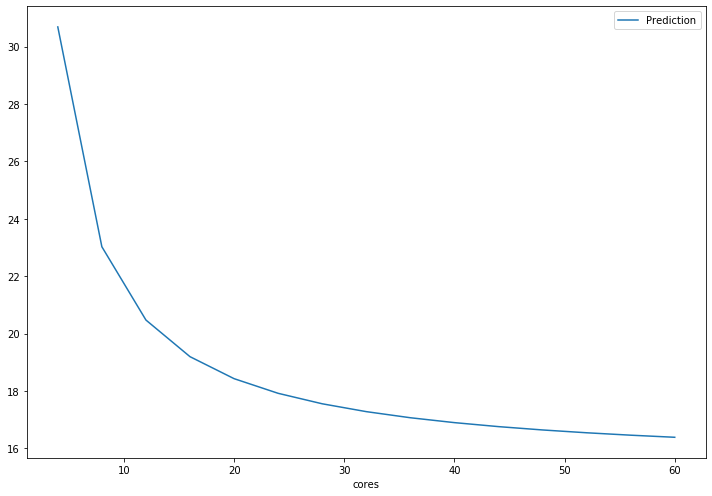

In [456]:
# plot the result that we have got: 
import matplotlib.pyplot as mp
ernest_df.plot(x="cores", y=["Prediction"],
        kind="line", figsize=(10, 7))
 
# display plot
mp.show()

as we can see from the previous results, at some point we achieve a linear enhancement of the predicted time 

testing the model on our own data that extracted from each executor of the cluster

In [457]:
training_errors = []
predicted = []
predicted_arr = []
i = 0 
for p in test_data_arr :
    predicted= predict(p[0], p[1])
    training_errors.append(predicted - y_test_arr[i])
    i=i+1
    predicted_arr.append(predicted)
    #print(predicted)
    #print(predict(p[0], p[1]))
    



In [458]:
ernest_results_df = X_test
ernest_results_df['totalDuration'] = y_test
ernest_results_df['predicted_time'] = predicted_arr
ernest_results_df['training_error'] = training_errors
ernest_results_df

/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,totalCores,totalInputBytes,totalDuration,predicted_time,training_error
153,1,0.034259,14975,17467.612657,2492.612657
237,1,0.376914,36375,38457.352105,2082.352105
75,1,0.025982,15723,16960.563399,1237.563399
443,1,0.000131,5447,15377.038067,9930.038067
179,1,0.001028,24355,15432.004430,-8922.995570
36,1,0.027162,11467,17032.822550,5565.822550
71,1,0.000131,5447,15377.038067,9930.038067
361,1,0.000131,5763,15377.038067,9614.038067
130,1,0.001109,6869,15436.945226,8567.945226
315,1,0.020502,8077,16624.898025,8547.898025


In [459]:

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted_arr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted_arr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted_arr)))

Mean Absolute Error: 10740.183363152377
Mean Squared Error: 182629734.68526015
Root Mean Squared Error: 13514.05692918526


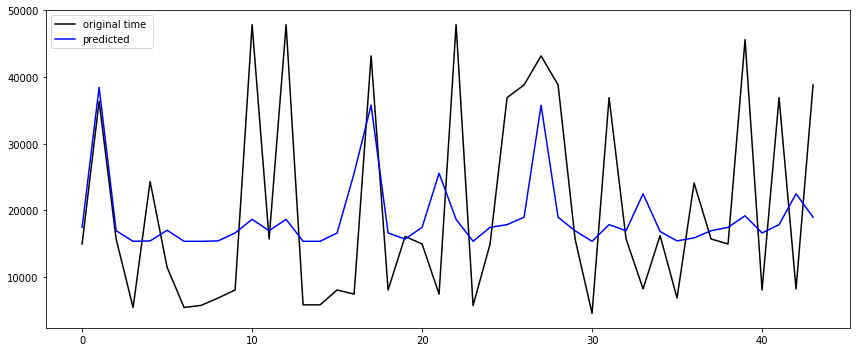

In [460]:
import matplotlib.pyplot as mp
mp.rcParams["figure.figsize"] = [12, 5]
mp.rcParams["figure.autolayout"] = True

#df = pd.DataFrame(dict(data=[2, 4, 1, 5, 9, 6, 0, 7]))
fig, ax = mp.subplots()
Train_Data_test_plot_ernest = ernest_results_df.reset_index()

Train_Data_test_plot_ernest['totalDuration'].plot( kind='line', color='black',  ms=10)

Train_Data_test_plot_ernest['predicted_time'].plot( kind='line',style=['-'], color='blue', ms=10)

ax.legend(labels=['original time ', 'predicted'])
mp.show()

In [461]:
training_errors = [str(np.around(i*100, 2)) + "%" for i in training_errors]
print ("Prediction ratios are", ", ".join(training_errors))

Prediction ratios are 249261.27%, 208235.21%, 123756.34%, 993003.81%, -892299.56%, 556582.26%, 993003.81%, 961403.81%, 856794.52%, 854789.8%, -2920070.02%, 123756.34%, -2920070.02%, 953303.81%, 953303.81%, 854789.8%, 1812639.36%, -739722.21%, 854789.8%, -39269.34%, 249261.27%, 1812639.36%, -2920070.02%, 964203.81%, 249261.27%, -1904893.32%, -1984941.56%, -739722.21%, -1984941.56%, 123756.34%, 1080903.81%, -1904893.32%, 123756.34%, 1426328.45%, 60663.07%, 856794.52%, -823975.11%, 123756.34%, 249261.27%, -2640985.89%, 854789.8%, -1904893.32%, 1426328.45%, -1984941.56%


lets plot the training error 

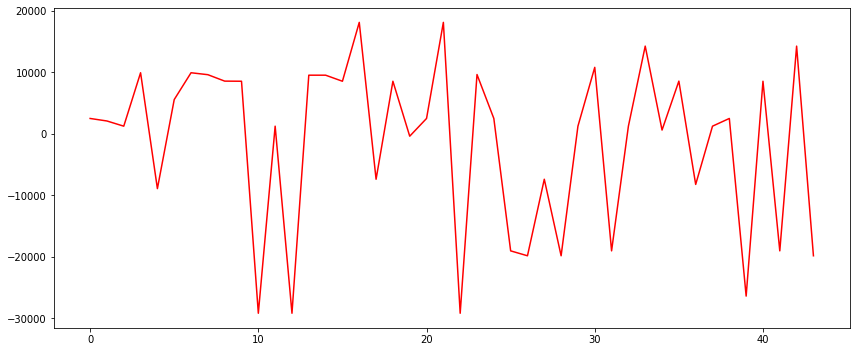

In [465]:
Train_Data_test_plot_ernest['training_error'].plot(kind='line', color='red', label= 'Training Error' )



## Then we try normal linearRegression model using our orginal dataset (features):

i will use with the normal linear regression another important extra variables in the train data wich is totalTasks, totalShuffleRead, totalShuffleWrite. but first lets check the correlation matrix of the variables that i have 

before applying the linear regression model, let's check the correlation between aour variables. 

In [466]:
import pandas as pd
import numpy as np
corr = tpot_max_scaled.corr()
corr.style.background_gradient(cmap='coolwarm')

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
totalCores,1.000000,0.332074,0.214159,-0.190419,-0.233803,0.953041,0.349595
totalTasks,0.332074,1.000000,-0.064651,-0.048801,-0.060298,0.201013,0.935904
totalInputBytes,0.214159,-0.064651,1.000000,0.037448,0.136538,0.319344,-0.012781
totalShuffleRead,-0.190419,-0.048801,0.037448,1.000000,0.878631,-0.183412,0.023747
totalShuffleWrite,-0.233803,-0.060298,0.136538,0.878631,1.000000,-0.224982,0.024441
maxMemory,0.953041,0.201013,0.319344,-0.183412,-0.224982,1.000000,0.221920
totalDuration,0.349595,0.935904,-0.012781,0.023747,0.024441,0.221920,1.000000


In [467]:
linear_df = tpot_max_scaled.drop(['maxMemory'],axis='columns')
linear_df

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration
1,2,0.008066,0.000000,0.012550,0.011084,21757
2,2,0.004634,0.000000,0.004524,0.010772,20817
3,2,0.005092,0.000000,0.007714,0.010896,20800
5,2,0.008066,0.000000,0.012550,0.011084,21757
6,2,0.004634,0.000000,0.004524,0.010772,20817
...,...,...,...,...,...,...
461,1,0.001316,0.005555,0.000086,0.000094,16102
462,1,0.001201,0.032732,0.000012,0.000036,20120
464,1,0.001545,0.000000,0.006025,0.019879,21108
465,1,0.004863,0.008444,0.053365,0.058601,24126


In [468]:
corr = linear_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration
totalCores,1.000000,0.332074,0.214159,-0.190419,-0.233803,0.349595
totalTasks,0.332074,1.000000,-0.064651,-0.048801,-0.060298,0.935904
totalInputBytes,0.214159,-0.064651,1.000000,0.037448,0.136538,-0.012781
totalShuffleRead,-0.190419,-0.048801,0.037448,1.000000,0.878631,0.023747
totalShuffleWrite,-0.233803,-0.060298,0.136538,0.878631,1.000000,0.024441
totalDuration,0.349595,0.935904,-0.012781,0.023747,0.024441,1.000000


In [469]:
inputs=linear_df.drop(['totalDuration'],axis='columns')
target=linear_df['totalDuration']

our target data here will be totalDuration as well 

In [470]:
X=inputs
Y=target

In [471]:
#splitting the data between training data and test data : 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(161, 5)
(80, 5)
(161,)
(80,)


In [472]:
# basic linear regression : 
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,Y_train)
Y_pred_train = lm.predict(X_train) #predictions on training data
Y_pred = lm.predict(X_test) #predictions on testing data
# We plot predicted Y (y-axis) against actual Y (x-axis).
Train_Data_test=X_test.copy()

Train_Data_test['totalDuration']=Y_test
Train_Data_test['time_pred']=Y_pred 
#Train_Data_test
#import matplotlib.pyplot as plt
#plt.scatter(Y_test, Y_pred)
#plt.xlabel("Actual time: $Y_i$" )
#plt.ylabel("Predicted time: $\hat{Y}_i$")
#plt.title("Predicted time vs Actual time: $Y_i$ vs $\hat{Y}_i$")
#plt.show()

In [473]:
Train_Data_test.head(10)

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration,time_pred
355,1,0.001087,0.025982,3.408678e-05,0.000139,15723,13928.847275
315,1,0.002918,0.020502,8.323106e-05,0.000110,8077,14645.158102
241,1,0.000286,0.000000,0.000000e+00,0.000000,4382,13325.459284
366,1,0.013330,0.001018,5.807301e-07,0.000010,23337,18840.038458
90,1,0.001201,0.032732,1.249607e-05,0.000036,20120,14041.326103
307,1,0.000572,0.001109,2.033592e-05,0.000027,7353,13458.153245
373,1,0.004863,0.008444,5.336548e-02,0.058601,24126,17194.335800
110,2,0.023913,1.000000,2.785225e-02,0.028975,43965,41679.584156
349,1,0.000973,0.000131,0.000000e+00,0.000000,5735,13616.459436
103,2,0.003204,0.000000,0.000000e+00,0.000001,12298,21996.889300


In [474]:
Train_Data_test["time_pred"]=Train_Data_test["time_pred"]/60
Train_Data_test["totalDuration"]=Train_Data_test["totalDuration"]/60
Train_Data_test["training_error"]=abs(Train_Data_test["totalDuration"]-Train_Data_test["time_pred"])


In [475]:
Train_Data_test.head()

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration,time_pred,training_error
355,1,0.001087,0.025982,3.408678e-05,0.000139,262.050000,232.147455,29.902545
315,1,0.002918,0.020502,8.323106e-05,0.000110,134.616667,244.085968,109.469302
241,1,0.000286,0.000000,0.000000e+00,0.000000,73.033333,222.090988,149.057655
366,1,0.013330,0.001018,5.807301e-07,0.000010,388.950000,314.000641,74.949359
90,1,0.001201,0.032732,1.249607e-05,0.000036,335.333333,234.022102,101.311232


now lets compare our results, the total duration with the time prediction

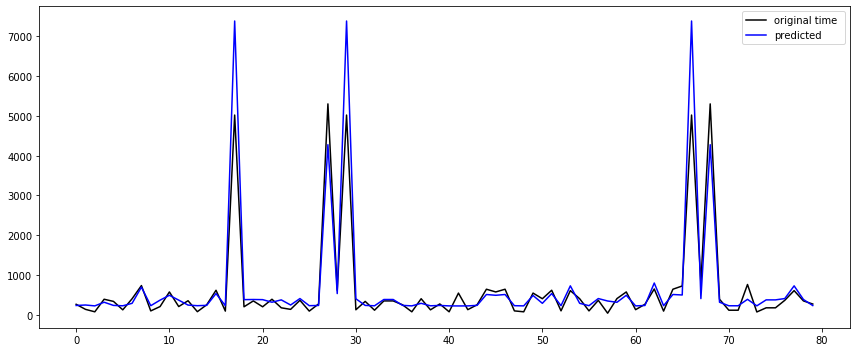

In [476]:

import matplotlib.pyplot as mp
mp.rcParams["figure.figsize"] = [12, 5]
mp.rcParams["figure.autolayout"] = True

#df = pd.DataFrame(dict(data=[2, 4, 1, 5, 9, 6, 0, 7]))
fig, ax = mp.subplots()
Train_Data_test_plot_linear = Train_Data_test.reset_index()

Train_Data_test_plot_linear['totalDuration'].plot(kind='line', color='black', ms=10)

Train_Data_test_plot_linear['time_pred'].plot(kind='line',style=['-'], color='blue', ms=10)

ax.legend(labels=['original time ', 'predicted'])


mp.show()

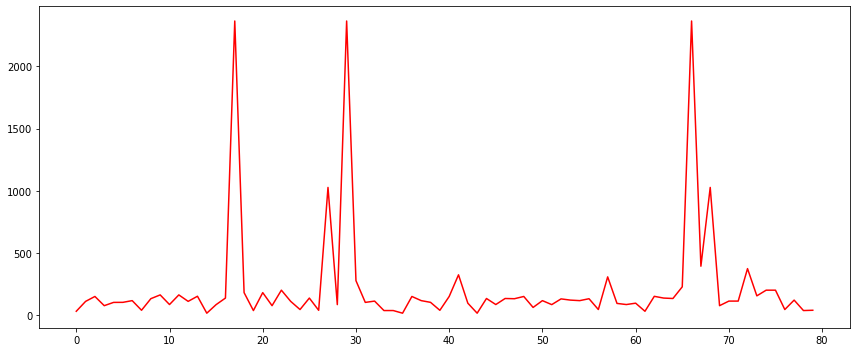

In [477]:

Train_Data_test_plot_linear['training_error'].plot(kind='line', color='red', label= 'Training Error' )



In [478]:
print(lm.intercept_)


5764.527708730133


In [479]:
print(lm.coef_)


[  7440.22943933 421974.66855387  10033.07801056  -3653.31576693
  34946.12224496]


In [480]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 13563.864181831206
Mean Squared Error: 917895818.1261041
Root Mean Squared Error: 30296.795509197076


In [481]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
totalCores,7440.229439
totalTasks,421974.668554
totalInputBytes,10033.078011
totalShuffleRead,-3653.315767
totalShuffleWrite,34946.122245


### Though our model in this case is not very precise

 ## -----------------------------------------------------------------------

# now we are gonna try DecisionTree in order to predict the execution time again: 

In [482]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [483]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

In [484]:
model=DecisionTreeClassifier(random_state=0)

In [485]:
# spliting the data: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, ) # 70% training and 30% test


In [486]:
X_train.count()

totalCores           168
totalTasks           168
totalInputBytes      168
totalShuffleRead     168
totalShuffleWrite    168
dtype: int64

In [487]:
X_test.count()

totalCores           73
totalTasks           73
totalInputBytes      73
totalShuffleRead     73
totalShuffleWrite    73
dtype: int64

In [488]:
# fiting the model: 
model.fit(X_train,y_train).tree_.node_count

83

In [489]:
pred = model.predict(X_test)

In [490]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.8767123287671232


as we can see the Accuracy that we have got is considered as a good accuracy 

In [491]:
model=DecisionTreeClassifier(ccp_alpha=0.001, random_state=0)

In [492]:
model.fit(X_train,y_train).tree_.node_count

83

In [493]:
X_test["totalDuration"]=y_test

/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [494]:
X_test["time_prediction"]=pred.tolist()

/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [495]:
X_test["totalDuration"]=X_test["totalDuration"]/60
X_test["time_prediction"]=X_test["time_prediction"]/60


/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [496]:
X_test.head(10)

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration,time_prediction
130,1,0.000572,0.001109,0.000020,0.000027,114.483333,122.550000
467,1,0.000973,0.000131,0.000000,0.000000,76.133333,90.783333
391,2,0.000114,0.333333,0.000000,0.000000,124.200000,124.200000
245,1,0.001316,0.034259,0.000094,0.000137,249.583333,249.583333
176,1,0.005034,0.040878,0.127632,0.476208,615.366667,615.366667
427,1,0.000343,0.004406,0.000044,0.000058,69.250000,69.250000
107,2,0.021625,0.000000,0.000097,0.000209,722.983333,722.983333
363,1,0.004119,0.016908,0.549679,0.497910,641.133333,641.133333
347,2,1.000000,0.000000,0.015789,0.022408,5023.100000,5023.100000
6,2,0.004634,0.000000,0.004524,0.010772,346.950000,346.950000


In [497]:
X_test["training_error"]=abs(X_test["totalDuration"]-X_test["time_prediction"])



/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [498]:
X_test

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration,time_prediction,training_error
130,1,0.000572,0.001109,0.000020,0.000027,114.483333,122.550000,8.066667
467,1,0.000973,0.000131,0.000000,0.000000,76.133333,90.783333,14.650000
391,2,0.000114,0.333333,0.000000,0.000000,124.200000,124.200000,0.000000
245,1,0.001316,0.034259,0.000094,0.000137,249.583333,249.583333,0.000000
176,1,0.005034,0.040878,0.127632,0.476208,615.366667,615.366667,0.000000
...,...,...,...,...,...,...,...,...
316,1,0.001259,0.027162,0.000023,0.000031,191.116667,191.116667,0.000000
299,2,0.000114,0.333333,0.000000,0.000000,124.200000,124.200000,0.000000
191,2,0.005092,0.000000,0.007714,0.010896,346.666667,346.666667,0.000000
341,1,0.001316,0.034259,0.000094,0.000137,249.583333,249.583333,0.000000


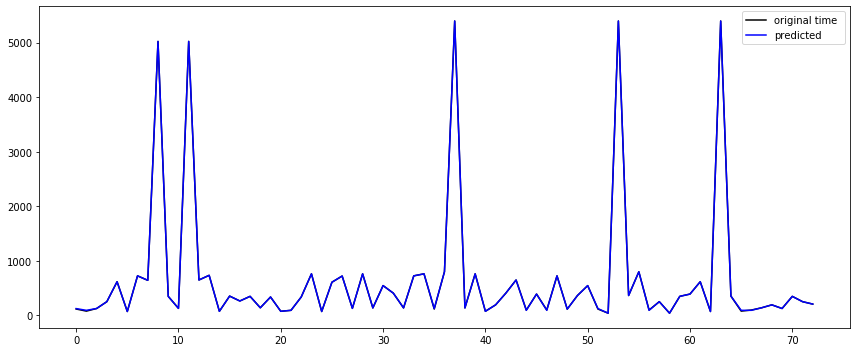

In [499]:
import matplotlib.pyplot as mp
mp.rcParams["figure.figsize"] = [12, 5]
mp.rcParams["figure.autolayout"] = True

#df = pd.DataFrame(dict(data=[2, 4, 1, 5, 9, 6, 0, 7]))
fig, ax = mp.subplots()
Train_Data_test_plot_decision = X_test.reset_index()

Train_Data_test_plot_decision['totalDuration'].plot(kind='line', color='black', ms=10)

Train_Data_test_plot_decision['time_prediction'].plot(kind='line',style=['-'], color='blue', ms=10)
ax.legend(labels=['original time ', 'predicted'])


mp.show()

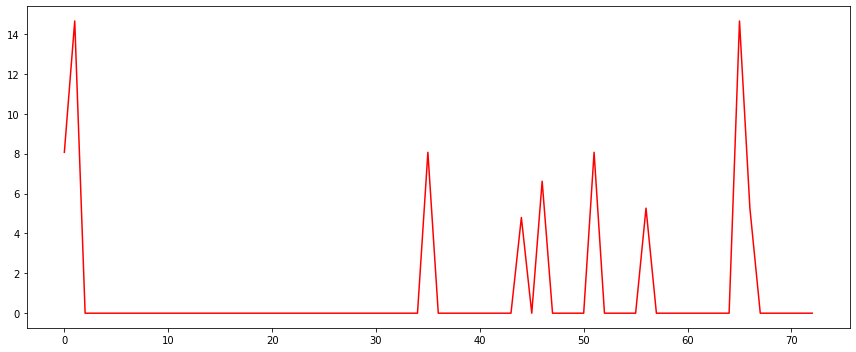

In [500]:
Train_Data_test_plot_decision['training_error'].plot(kind='line', color='red', label= 'Training Error' )



In [501]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 62.013698630136986
Mean Squared Error: 36826.232876712325
Root Mean Squared Error: 191.90162291317998


In [502]:

from sklearn.metrics import mean_squared_error, mean_absolute_error




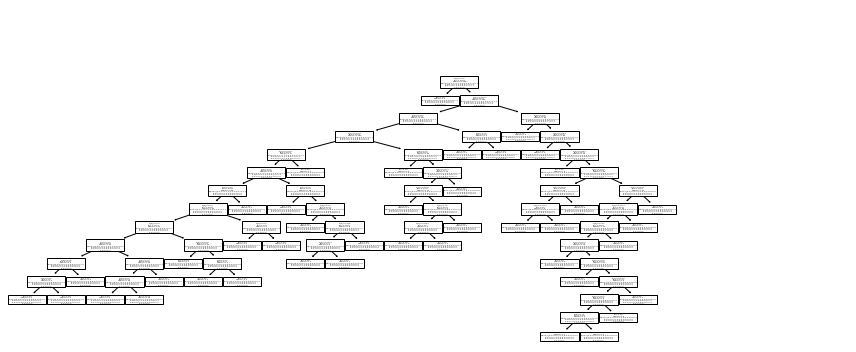

In [503]:
tree.plot_tree(model);

# -----------------------------------------------------------------------------------------

## next i am gonna try to use tpot library in order to figure out the best predection model based on our variables in the original data set:

In [204]:
conda install numpy scipy scikit-learn pandas joblib pytorch


Solving environment: done

## Package Plan ##

  environment location: /Users/diaaab/opt/anaconda3

  added / updated specs:
    - joblib
    - numpy
    - pandas
    - pytorch
    - scikit-learn
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.9.0               |   py37hecd8cb5_0         877 KB
    ------------------------------------------------------------
                                           Total:         877 KB

The following packages will be UPDATED:

  conda              conda-forge::conda-4.14.0-py37hf98548~ --> pkgs/main::conda-22.9.0-py37hecd8cb5_0



conda-22.9.0         | 877 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [205]:
conda install -c conda-forge tpot


Solving environment: done

## Package Plan ##

  environment location: /Users/diaaab/opt/anaconda3

  added / updated specs:
    - tpot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.9.0               |   py37hf985489_1         973 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         973 KB

The following packages will be UPDATED:

  conda              pkgs/main::conda-22.9.0-py37hecd8cb5_0 --> conda-forge::conda-22.9.0-py37hf985489_1 None



conda-22.9.0         | 973 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [504]:
tpot_max_scaled


,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,maxMemory,totalDuration
1,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
2,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
3,2,0.005092,0.000000,0.007714,0.010896,0.647292,20800
5,2,0.008066,0.000000,0.012550,0.011084,0.647292,21757
6,2,0.004634,0.000000,0.004524,0.010772,0.647292,20817
...,...,...,...,...,...,...,...
461,1,0.001316,0.005555,0.000086,0.000094,0.118280,16102
462,1,0.001201,0.032732,0.000012,0.000036,0.118280,20120
464,1,0.001545,0.000000,0.006025,0.019879,0.118280,21108
465,1,0.004863,0.008444,0.053365,0.058601,0.118280,24126


as we can see from the previous data fram, after deleting the duplicated rows, in order to get better performance from our model.

In [506]:
inputs2=tpot_max_scaled.drop(['totalDuration','maxMemory'],axis='columns')
target2=tpot_max_scaled['totalDuration']

In [507]:
inputs2

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite
1,2,0.008066,0.000000,0.012550,0.011084
2,2,0.004634,0.000000,0.004524,0.010772
3,2,0.005092,0.000000,0.007714,0.010896
5,2,0.008066,0.000000,0.012550,0.011084
6,2,0.004634,0.000000,0.004524,0.010772
...,...,...,...,...,...
461,1,0.001316,0.005555,0.000086,0.000094
462,1,0.001201,0.032732,0.000012,0.000036
464,1,0.001545,0.000000,0.006025,0.019879
465,1,0.004863,0.008444,0.053365,0.058601


In [508]:
print(inputs2.shape)
print(target2.shape)

(241, 5)
(241,)


In [509]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [510]:
# define evaluation procedure
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [511]:
X_train, X_test, y_train, y_test = train_test_split(inputs2, target2,
                                                    train_size=0.80, test_size=0.20)

trying tpotRegressor

In [512]:
from tpot import TPOTRegressor
tpot_model = TPOTRegressor(generations=5, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=1, n_jobs=-1)


In [210]:
tpot_model.fit(X_train, y_train)
tpot_model.export('time_orediction_best_model.py')

Version 0.11.6.post3 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.



Generation 1 - Current best internal CV score: -44.91575093882581

Generation 2 - Current best internal CV score: -44.91575093882581

Generation 3 - Current best internal CV score: -44.57431578947369

Generation 4 - Current best internal CV score: -44.57431578947369

Generation 5 - Current best internal CV score: -44.225005847953206

Best pipeline: KNeighborsRegressor(ElasticNetCV(CombineDFs(input_matrix, input_matrix), l1_ratio=0.4, tol=0.1), n_neighbors=15, p=1, weights=distance)


In [513]:
X_train, X_test, y_train, y_test = train_test_split(inputs2, target2,
                                                    train_size=0.75, test_size=0.25)

In [514]:
X_test

,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite
291,2,0.003204,0.000000,0.000000,0.000001
63,1,0.000572,0.004303,0.000062,0.000082
90,1,0.001201,0.032732,0.000012,0.000036
236,1,0.006522,0.058991,1.000000,1.000000
441,1,0.000973,0.000131,0.000000,0.000000
...,...,...,...,...,...
437,2,0.557952,0.000000,0.011873,0.016885
145,1,0.007494,0.376914,0.142050,0.684849
265,1,0.000973,0.000131,0.000000,0.000000
438,2,0.569622,0.000000,0.014920,0.016973


trying to KNeighborsRegressor on our data to see the prediction acurracy 

In [515]:
X_KNeighborsRegressor = X_train
Y_KNeighborsRegressor = y_train

trying first with number of kneighbors = 3 

In [516]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_KNeighborsRegressor, Y_KNeighborsRegressor)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [517]:
predected = (neigh.predict(X_test))

#print(neigh.predict_proba([[0.9]]))



In [518]:
KNeighbors_df = X_test 
KNeighbors_df['totalDuration'] = y_test
KNeighbors_df['prediction'] = predected

KNeighbors_df

/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,totalCores,totalTasks,totalInputBytes,totalShuffleRead,totalShuffleWrite,totalDuration,prediction
291,2,0.003204,0.000000,0.000000,0.000001,12298,12298.0
63,1,0.000572,0.004303,0.000062,0.000082,6784,6784.0
90,1,0.001201,0.032732,0.000012,0.000036,20120,20120.0
236,1,0.006522,0.058991,1.000000,1.000000,38832,38832.0
441,1,0.000973,0.000131,0.000000,0.000000,5735,4568.0
...,...,...,...,...,...,...,...
437,2,0.557952,0.000000,0.011873,0.016885,318229,318229.0
145,1,0.007494,0.376914,0.142050,0.684849,36375,36375.0
265,1,0.000973,0.000131,0.000000,0.000000,5763,4568.0
438,2,0.569622,0.000000,0.014920,0.016973,323840,323840.0


In [519]:
KNeighbors_df["training_error"]=abs(KNeighbors_df["totalDuration"]-KNeighbors_df["prediction"])



/Users/diaaab/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [520]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predected))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predected))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predected)))

Mean Absolute Error: 413.2568306010929
Mean Squared Error: 869682.8123861569
Root Mean Squared Error: 932.5678594001387


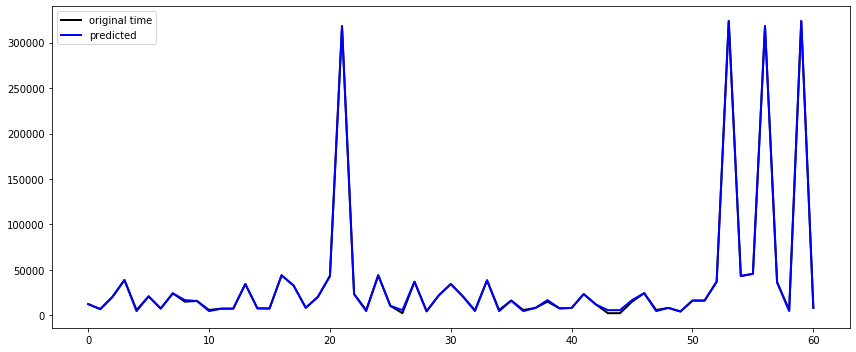

In [521]:
import matplotlib.pyplot as mp
mp.rcParams["figure.figsize"] = [12, 5]
mp.rcParams["figure.autolayout"] = True

#df = pd.DataFrame(dict(data=[2, 4, 1, 5, 9, 6, 0, 7]))
fig, ax = mp.subplots()
Train_Data_test_plot_kneighpors = KNeighbors_df.reset_index()

#Train_Data_test_plot['training_error'].plot(kind='bar', color='red')
Train_Data_test_plot_kneighpors['totalDuration'].plot(kind='line', color='black', ms=10, linewidth=2)

Train_Data_test_plot_kneighpors['prediction'].plot(kind='line',style=['-'], color='blue', ms=10, linewidth=2)
ax.legend(labels=['original time', 'predicted'])

mp.show()

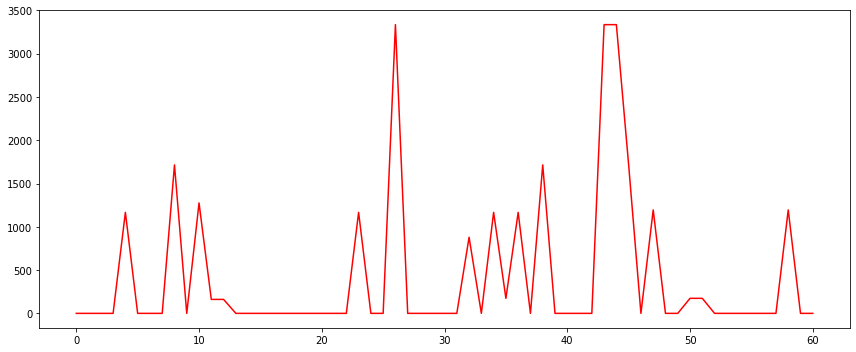

In [522]:
Train_Data_test_plot_kneighpors['training_error'].plot(kind='line', color='red', label= 'Training Error' )



plot the training errors for all the previous models togather to compare:

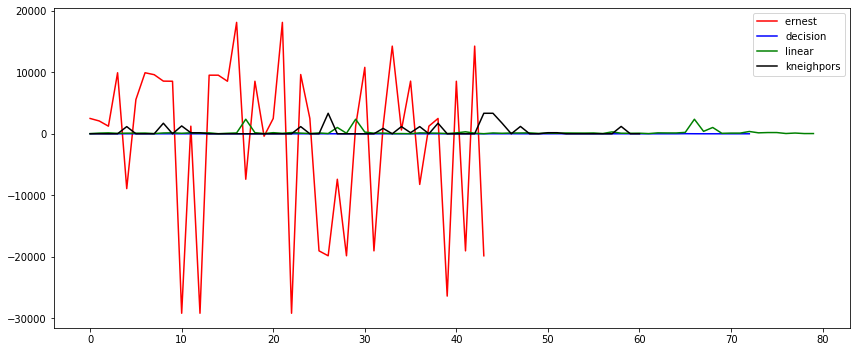

In [523]:
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt

mp.rcParams["figure.figsize"] = [12, 5]

fig, ax = mp.subplots()

Train_Data_test_plot_ernest['training_error'].plot(kind='line', color='red', label = 'ernest' )

Train_Data_test_plot_decision['training_error'].plot(kind='line', color='blue', label = 'decision' )

Train_Data_test_plot_linear['training_error'].plot(kind='line', color='green', label = 'linear' )

Train_Data_test_plot_kneighpors['training_error'].plot(kind='line', color='black', label = 'kneighpors' )
ax.legend(labels=['ernest ', 'decision', 'linear', 'kneighpors'])

mp.show()